<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/weather(UV_index)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import sklearn
import xgboost


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# **Getting Weather Data**

In [370]:
import requests
import csv

# API Key
API_KEY = "4091f433030f47658ea85020253001"

# List of major cities in Kenya
kenyan_cities = [
    "Nairobi", "Mombasa", "Kisumu", "Nakuru", "Eldoret", "Malindi", "Thika",
    "Kitale", "Garissa", "Kakamega", "Kericho", "Lamu", "Meru", "Nyeri",
    "Embu", "Voi", "Machakos", "Bomet", "Kisii", "Bungoma", "Siaya",
    "Homa Bay", "Kisumu", "Lodwar", "Taveta", "Kitui", "Murang'a",
    "Isiolo", "Mwingi", "Ruiru", "Kiambu", "Nandi Hills", "Samburu",
    "Chuka", "Kendu Bay", "Wajir", "Mandera", "Marsabit", "Baringo",
    "Taita", "Nyamira", "Laikipia", "Trans Nzoia", "Kajiado"
]

# File name for CSV output
filename = "kenya_weather_data.csv"

# Open CSV file and write headers
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Writing header row
    headers = [
        "City", "Country", "Latitude", "Longitude", "Local Time",
        "Temperature (°C)", "Feels Like (°C)", "Humidity (%)", "Pressure (mb)",
        "Wind Speed (km/h)", "Wind Direction", "UV Index", "Visibility (km)", "Weather Condition",
        "Air Quality Index (US)", "PM2.5", "PM10", "CO (Carbon Monoxide)", "NO2 (Nitrogen Dioxide)", "SO2 (Sulfur Dioxide)",
        "Tomorrow's Max Temp (°C)", "Tomorrow's Min Temp (°C)", "Tomorrow's Condition", "Sunrise", "Sunset"
    ]
    writer.writerow(headers)

    # Loop through each city and fetch weather data
    for city in kenyan_cities:
        try:
            URL = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city}&days=3&aqi=yes"
            response = requests.get(URL)
            data = response.json()

            # Extract comprehensive weather details
            weather_data = [
                data["location"]["name"],
                data["location"]["country"],
                data["location"]["lat"],
                data["location"]["lon"],
                data["location"]["localtime"],

                # Current Weather
                data["current"]["temp_c"],
                data["current"]["feelslike_c"],
                data["current"]["humidity"],
                data["current"]["pressure_mb"],
                data["current"]["wind_kph"],
                data["current"]["wind_dir"],
                data["current"]["uv"],
                data["current"]["vis_km"],
                data["current"]["condition"]["text"],

                # Air Quality Data
                data["current"]["air_quality"].get("us-epa-index", "N/A"),
                data["current"]["air_quality"].get("pm2_5", "N/A"),
                data["current"]["air_quality"].get("pm10", "N/A"),
                data["current"]["air_quality"].get("co", "N/A"),
                data["current"]["air_quality"].get("no2", "N/A"),
                data["current"]["air_quality"].get("so2", "N/A"),

                # Forecast (Next Day)
                data["forecast"]["forecastday"][1]["day"]["maxtemp_c"],
                data["forecast"]["forecastday"][1]["day"]["mintemp_c"],
                data["forecast"]["forecastday"][1]["day"]["condition"]["text"],
                data["forecast"]["forecastday"][1]["astro"]["sunrise"],
                data["forecast"]["forecastday"][1]["astro"]["sunset"],
            ]

            # Write data row
            writer.writerow(weather_data)
            print(f"✅ Weather data for {city} saved.")

        except Exception as e:
            print(f"❌ Error fetching data for {city}: {e}")

print(f"\n🎉 Comprehensive weather data for Kenya saved to {filename} successfully!")


✅ Weather data for Nairobi saved.
✅ Weather data for Mombasa saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Nakuru saved.
✅ Weather data for Eldoret saved.
✅ Weather data for Malindi saved.
✅ Weather data for Thika saved.
✅ Weather data for Kitale saved.
✅ Weather data for Garissa saved.
✅ Weather data for Kakamega saved.
✅ Weather data for Kericho saved.
✅ Weather data for Lamu saved.
✅ Weather data for Meru saved.
✅ Weather data for Nyeri saved.
✅ Weather data for Embu saved.
✅ Weather data for Voi saved.
✅ Weather data for Machakos saved.
✅ Weather data for Bomet saved.
✅ Weather data for Kisii saved.
✅ Weather data for Bungoma saved.
✅ Weather data for Siaya saved.
✅ Weather data for Homa Bay saved.
✅ Weather data for Kisumu saved.
✅ Weather data for Lodwar saved.
✅ Weather data for Taveta saved.
✅ Weather data for Kitui saved.
✅ Weather data for Murang'a saved.
✅ Weather data for Isiolo saved.
✅ Weather data for Mwingi saved.
✅ Weather data for Ruiru saved.
✅ Weather d

In [415]:
import csv

# List of sunscreens with their SPF ratings
sunscreens = [
    ["Neutrogena Ultra Sheer Dry-Touch Sunscreen", 100],
    ["EltaMD UV Clear Broad-Spectrum Sunscreen", 46],
    ["Supergoop! Unseen Sunscreen", 40],
    ["La Roche-Posay Anthelios Melt-in Milk Sunscreen", 60],
    ["CeraVe Hydrating Mineral Sunscreen", 30],
    ["Banana Boat Ultra Sport Sunscreen", 50],
    ["Hawaiian Tropic Sheer Touch Lotion Sunscreen", 30],
    ["Blue Lizard Sensitive Mineral Sunscreen", 50],
    ["Coppertone Sport Sunscreen Spray", 50],
    ["Aveeno Protect + Hydrate Sunscreen", 60],
    ["Bioré UV Aqua Rich Watery Essence", 50],
    ["Sun Bum Original Sunscreen Lotion", 50],
    ["Shiseido Ultimate Sun Protector Lotion", 50],
    ["Thinkbaby Safe Sunscreen", 50],
    ["Coola Classic Face Sunscreen", 30],
    ["Australian Gold Botanical Sunscreen Tinted Face", 50],
    ["Eucerin Daily Hydration Sunscreen", 30],
    ["Babo Botanicals Clear Zinc Sunscreen", 30],
    ["ISDIN Eryfotona Actinica Mineral Sunscreen", 50],
    ["Alba Botanica Hawaiian Sunscreen", 45],
    ["Vanicream Sunscreen Sport", 35],
    ["Paula’s Choice Resist Super-Light Daily Wrinkle Defense", 30],
    ["Innisfree Daily UV Defense Sunscreen", 36],
    ["Badger Clear Zinc Sunscreen Cream", 40],
    ["Derma E Sun Defense Mineral Oil-Free Sunscreen", 30],
    ["Dr. Jart+ Every Sun Day Mineral Sunscreen", 50],
    ["Black Girl Sunscreen", 30],
    ["MD Solar Sciences Mineral Crème Sunscreen", 50],
    ["Peter Thomas Roth Water Drench Broad Spectrum Sunscreen", 45],
    ["Alastin HydraTint Pro Mineral Sunscreen", 36]
]

# Save as a CSV file
filename = "sunscreens.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Sunscreen Name", "SPF"])
    writer.writerows(sunscreens)

print(f"CSV file '{filename}' has been created successfully!")


CSV file 'sunscreens.csv' has been created successfully!


In [422]:
# Load sunscreen data
sunscreens= pd.read_csv("sunscreens.csv")
sunscreens.head()

,Sunscreen Name,SPF
0,Neutrogena Ultra Sheer Dry-Touch Sunscreen,100
1,EltaMD UV Clear Broad-Spectrum Sunscreen,46
2,Supergoop! Unseen Sunscreen,40
3,La Roche-Posay Anthelios Melt-in Milk Sunscreen,60
4,CeraVe Hydrating Mineral Sunscreen,30


In [371]:
# Load the dataset
df = pd.read_csv("kenya_weather_data.csv")
df.head()

,City,Country,Latitude,Longitude,Local Time,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),...,PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C),Tomorrow's Condition,Sunrise,Sunset
0,Nairobi,Kenya,-1.2833,36.8167,2025-02-11 17:23,27.2,26.2,37,1018.0,27.7,...,9.250,9.805,386.65,1.665,3.330,28.2,14.3,Sunny,06:42 AM,06:52 PM
1,Mombasa,Kenya,-4.0500,39.6667,2025-02-11 17:23,32.3,39.8,49,1008.0,28.1,...,15.540,21.275,222.00,1.480,4.625,29.4,25.3,Moderate rain,06:28 AM,06:43 PM
2,Kisumu,Kenya,-0.1000,34.7500,2025-02-11 17:23,31.9,30.6,27,1002.0,9.7,...,7.955,8.880,362.60,0.740,0.740,32.0,19.7,Sunny,06:52 AM,06:59 PM
3,Nakuru,Kenya,-0.2833,36.0667,2025-02-11 17:23,25.4,24.6,25,1007.0,25.2,...,5.920,6.475,283.05,0.555,0.740,28.3,13.0,Patchy rain nearby,06:46 AM,06:54 PM
4,Eldoret,Kenya,0.5167,35.2833,2025-02-11 17:23,27.1,25.7,23,1020.0,27.0,...,5.735,6.475,266.40,0.555,0.555,26.9,14.5,Sunny,06:50 AM,06:56 PM


# **Exploratory Data Analysis**

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   City                      42 non-null     object 
 1   Country                   42 non-null     object 
 2   Latitude                  42 non-null     float64
 3   Longitude                 42 non-null     float64
 4   Local Time                42 non-null     object 
 5   Temperature (°C)          42 non-null     float64
 6   Feels Like (°C)           42 non-null     float64
 7   Humidity (%)              42 non-null     int64  
 8   Pressure (mb)             42 non-null     float64
 9   Wind Speed (km/h)         42 non-null     float64
 10  Wind Direction            42 non-null     object 
 11  UV Index                  42 non-null     float64
 12  Visibility (km)           42 non-null     float64
 13  Weather Condition         42 non-null     object 
 14  Air Quality 

In [427]:
sunscreen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sunscreen Name  30 non-null     object
 1   SPF             30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes


In [373]:
df.describe()

,Latitude,Longitude,Temperature (°C),Feels Like (°C),Humidity (%),Pressure (mb),Wind Speed (km/h),UV Index,Visibility (km),Air Quality Index (US),PM2.5,PM10,CO (Carbon Monoxide),NO2 (Nitrogen Dioxide),SO2 (Sulfur Dioxide),Tomorrow's Max Temp (°C),Tomorrow's Min Temp (°C)
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,-0.649648,36.440771,28.769048,28.457143,33.833333,1009.261905,19.800000,1.747619,9.976190,1.119048,10.721190,16.306429,280.715476,0.792857,1.123214,29.485714,17.421429
std,10.599948,26.660281,5.953662,6.476906,15.029916,6.097019,8.696733,1.992821,0.154303,0.503761,13.756846,39.963083,73.174240,0.692551,1.323622,5.566563,5.601765
min,-41.200000,-46.850000,2.100000,-0.500000,15.000000,1002.000000,5.000000,0.000000,9.000000,1.000000,4.070000,4.625000,125.800000,0.185000,0.000000,3.500000,-1.700000
25%,-1.254150,34.825025,27.025000,25.925000,23.000000,1005.000000,12.200000,1.100000,10.000000,1.000000,7.400000,8.325000,234.487500,0.370000,0.555000,27.600000,14.325000
50%,-0.391700,36.825000,28.900000,27.950000,29.000000,1007.000000,20.500000,1.400000,10.000000,1.000000,7.955000,9.342500,263.625000,0.555000,0.740000,30.350000,17.500000
75%,0.333325,37.908300,31.900000,31.700000,39.000000,1015.500000,26.825000,1.675000,10.000000,1.000000,9.250000,10.406250,316.350000,0.878750,0.878750,32.000000,20.550000
max,46.766700,174.950000,37.300000,39.800000,77.000000,1023.000000,37.400000,12.500000,10.000000,4.000000,96.200000,267.880000,584.600000,3.330000,7.030000,37.400000,28.000000


In [374]:
#checking for null values
df.isnull().sum()

,0
City,0
Country,0
Latitude,0
Longitude,0
Local Time,0
Temperature (°C),0
Feels Like (°C),0
Humidity (%),0
Pressure (mb),0
Wind Speed (km/h),0


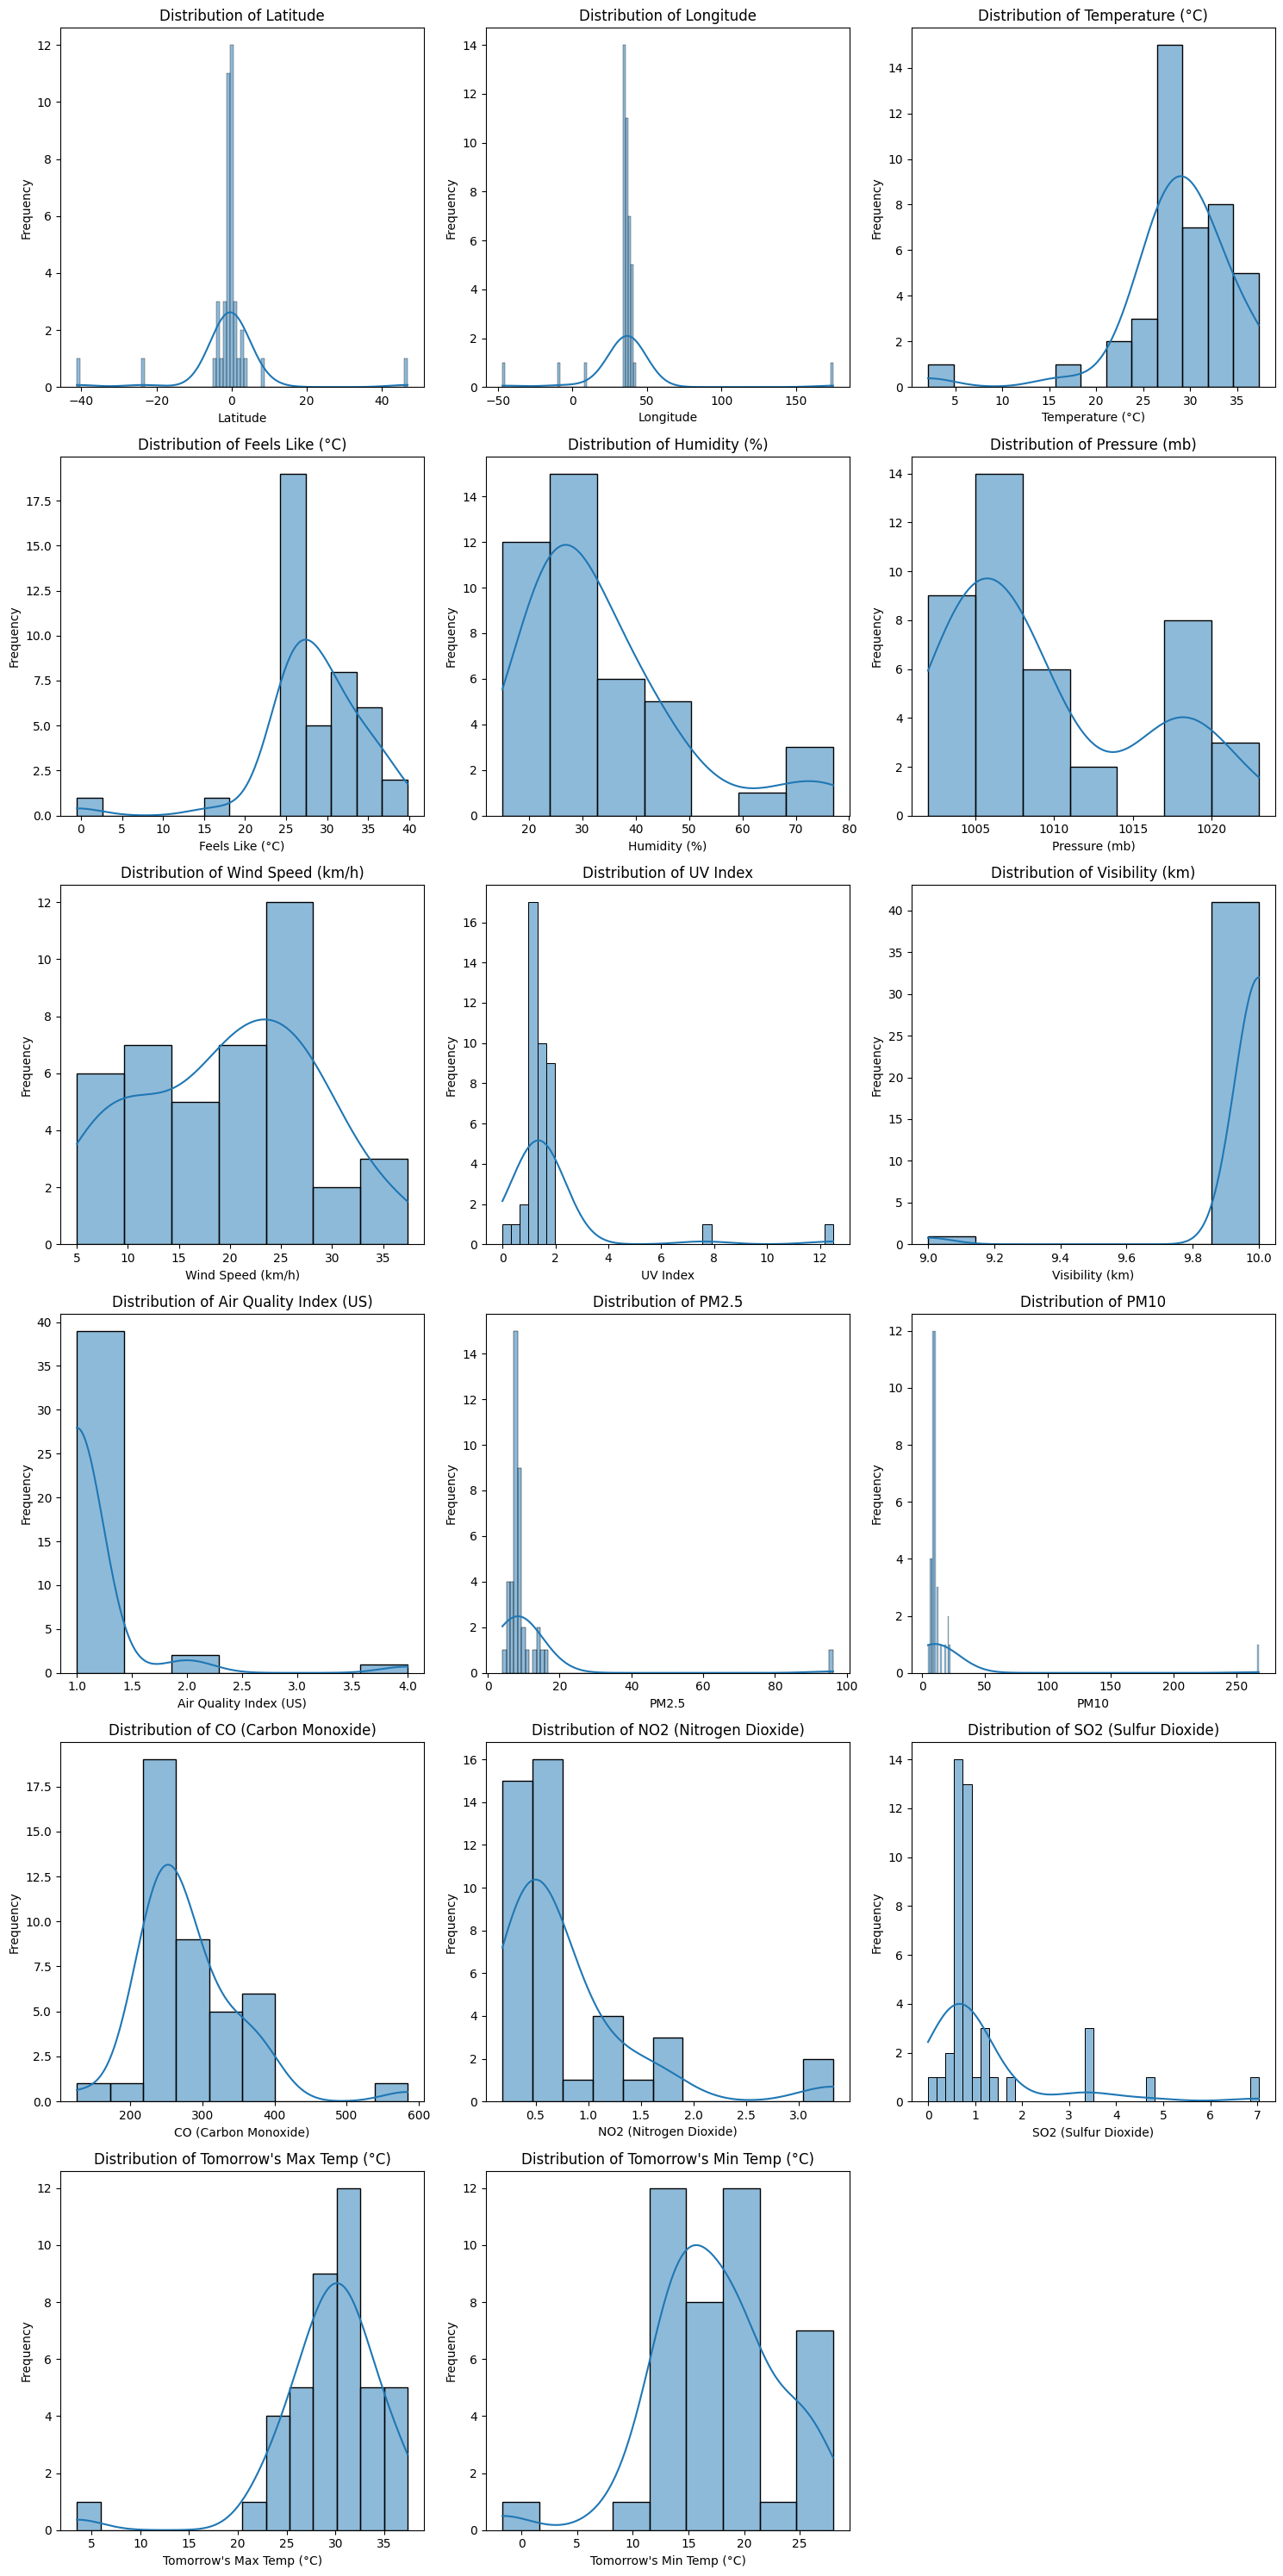

In [375]:
# Number of numerical features
num_features = len(df.select_dtypes(include=['float64', 'int64']).columns)

# Determine the number of rows and columns for the subplots
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Plotting the distribution of numerical features
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


<ipython-input-376-98f79b260d75>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.



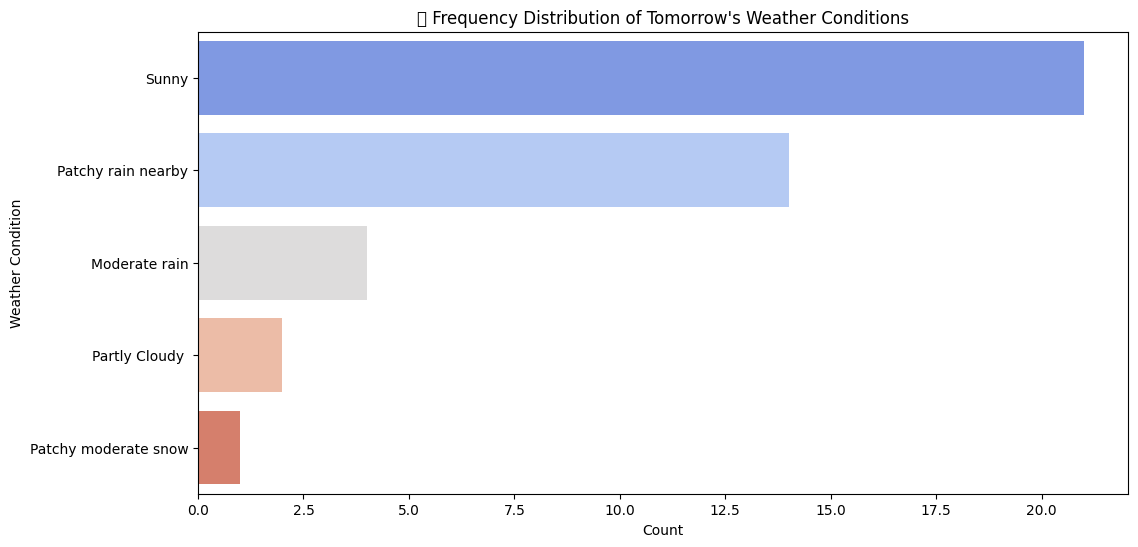

In [376]:
# 🔹 Plot Bar Chart for Tomorrow's Weather Condition
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Tomorrow's Condition"], order=df["Tomorrow's Condition"].value_counts().index, palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.title("📌 Frequency Distribution of Tomorrow's Weather Conditions")
plt.show()

In [377]:
# Select only numeric columns (int64 and float64)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation with 'UV Index'
uv_corr = numeric_df.corr()['UV Index']

# Display correlations
print(uv_corr)


Latitude                   -0.194905
Longitude                  -0.645626
Temperature (°C)            0.184792
Feels Like (°C)             0.205264
Humidity (%)               -0.079043
Pressure (mb)               0.107347
Wind Speed (km/h)          -0.313522
UV Index                    1.000000
Visibility (km)             0.075163
Air Quality Index (US)      0.395089
PM2.5                       0.498358
PM10                        0.470766
CO (Carbon Monoxide)        0.379770
NO2 (Nitrogen Dioxide)      0.540198
SO2 (Sulfur Dioxide)        0.647571
Tomorrow's Max Temp (°C)    0.184158
Tomorrow's Min Temp (°C)    0.087869
Name: UV Index, dtype: float64


In [378]:
df['Weather Condition'].value_counts()

,count
Weather Condition,
Sunny,18
Partly cloudy,12
Partly Cloudy,6
Patchy rain nearby,5
Overcast,1


# **Visualizations**

In [414]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Create a map centered around Kenya
m = folium.Map(location=[0.0236, 37.9062], zoom_start=6)

# Prepare data for the heat map
heat_data = [[row['Latitude'], row['Longitude'], row['Temperature (°C)']] for index, row in df.iterrows()]

# Add the heat map
HeatMap(heat_data).add_to(m)

# Save to an HTML file
m.save('kenya_temperature_heatmap.html')

m


In [379]:
# 🔹 Geospatial Map of Cities
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Temperature (°C)", size="Wind Speed (km/h)", mapbox_style="open-street-map", title="🌎 Temperature Across Kenya")
fig.show()

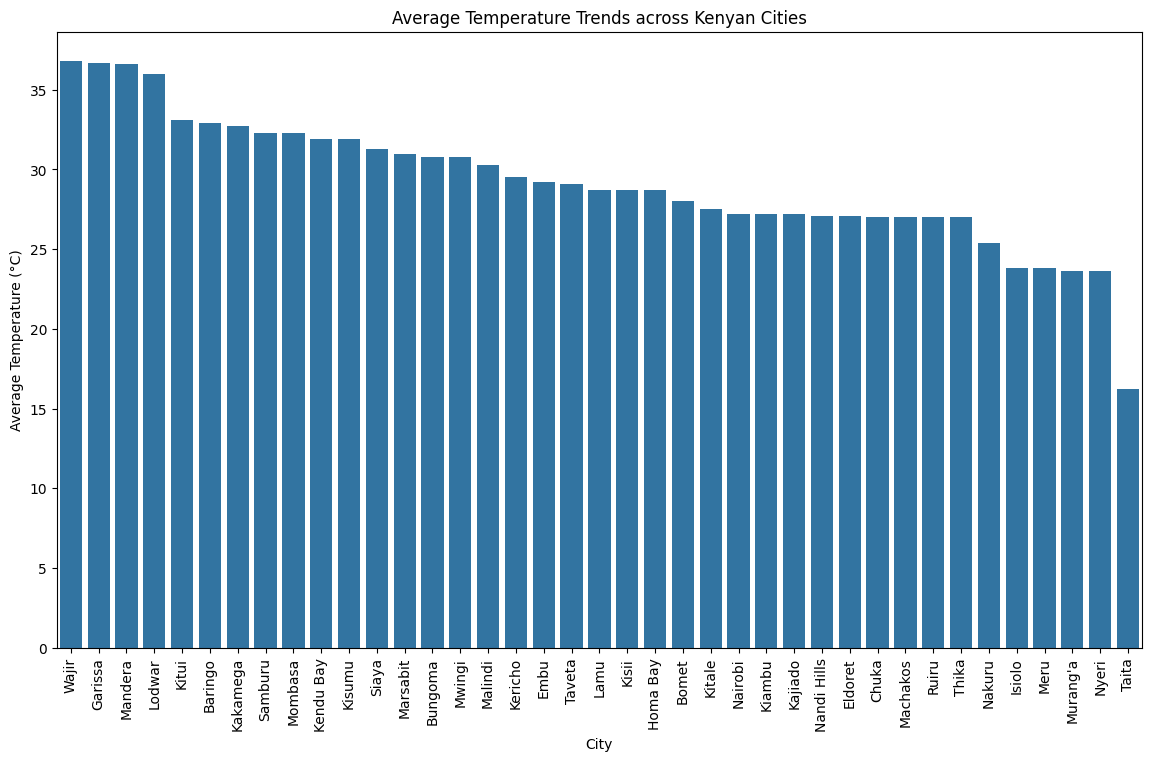

In [380]:
# Filter the DataFrame to include only the specified cities
df_filtered = df[df['City'].isin(kenyan_cities)]

# Calculate the average temperature for each city
avg_temp_by_city = df_filtered.groupby('City')['Temperature (°C)'].mean().reset_index()

# Sort the DataFrame by temperature in descending order
avg_temp_by_city = avg_temp_by_city.sort_values(by='Temperature (°C)', ascending=False)

# Vertical Bar Graph for Temperature Trends across Kenyan Cities
plt.figure(figsize=(14, 8))
sns.barplot(x='City', y='Temperature (°C)', data=avg_temp_by_city)
plt.title('Average Temperature Trends across Kenyan Cities')
plt.xlabel('City')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=90)
plt.show()

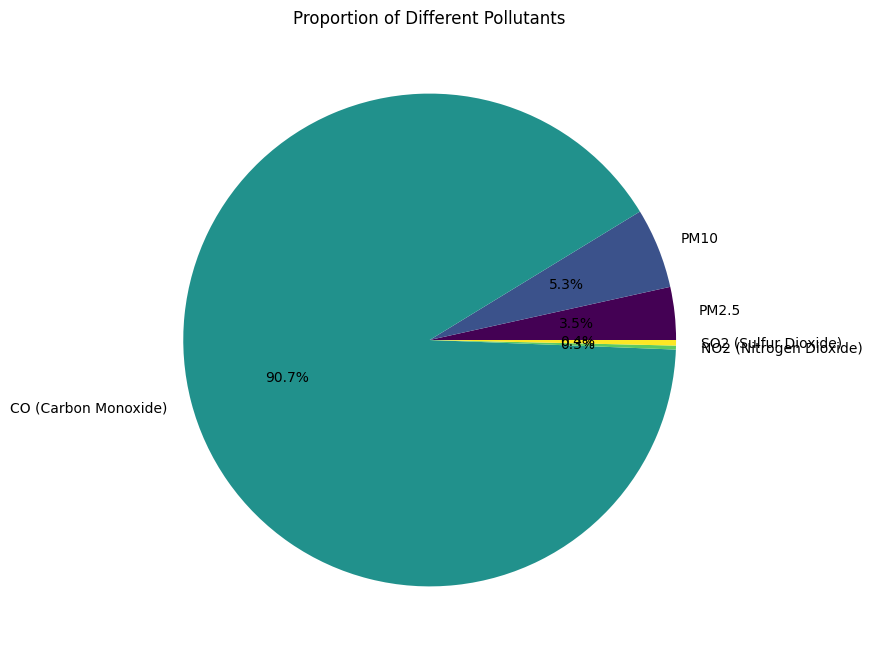

In [381]:
# Pie Chart for Pollutants
pollutants = ['PM2.5', 'PM10', 'CO (Carbon Monoxide)', 'NO2 (Nitrogen Dioxide)', 'SO2 (Sulfur Dioxide)']
pollutant_totals = df[pollutants].mean()

plt.figure(figsize=(8, 8))
plt.pie(pollutant_totals, labels=pollutants, autopct='%1.1f%%', colors=cm.viridis(np.linspace(0, 1, len(pollutants))))
plt.title('Proportion of Different Pollutants')
plt.show()

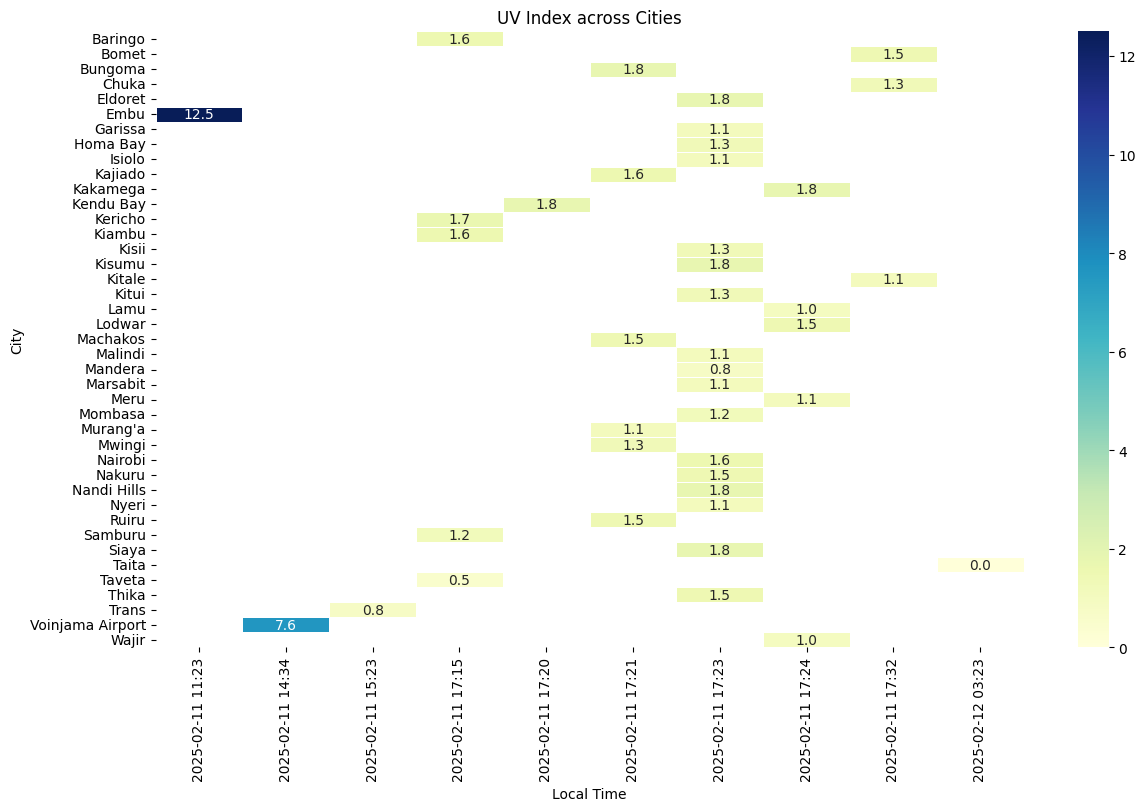

In [382]:

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(values='UV Index', index='City', columns='Local Time', aggfunc='mean')

# Heatmap for UV Index across Cities
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title('UV Index across Cities')
plt.xlabel('Local Time')
plt.ylabel('City')
plt.xticks(rotation=90)
plt.show()


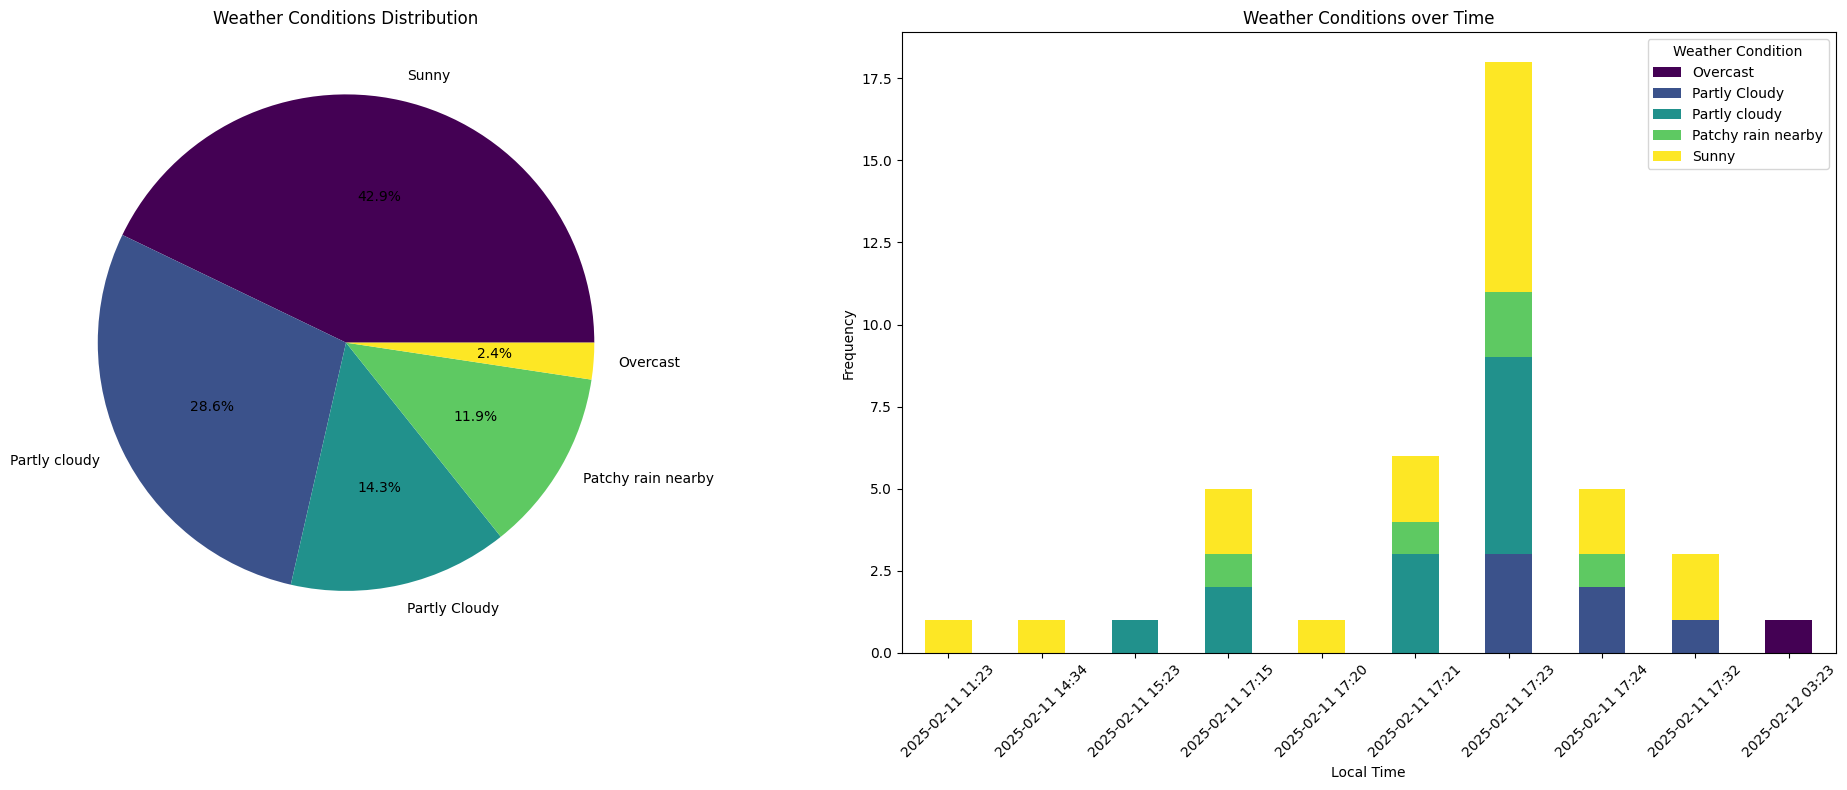

In [383]:
# Pie Chart for Weather Conditions
weather_conditions = df['Weather Condition'].value_counts()

# Stacked Bar Chart for Weather Conditions over Time
weather_time = pd.crosstab(df['Local Time'], df['Weather Condition'])

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pie Chart
axes[0].pie(weather_conditions, labels=weather_conditions.index, autopct='%1.1f%%',
            colors=plt.cm.viridis(np.linspace(0, 1, len(weather_conditions))))
axes[0].set_title('Weather Conditions Distribution')

# Stacked Bar Chart for Weather Conditions over Time
weather_time.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Weather Conditions over Time')
axes[1].set_xlabel('Local Time')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Weather Condition')

plt.tight_layout()
plt.show()


**correlation Heatmap**

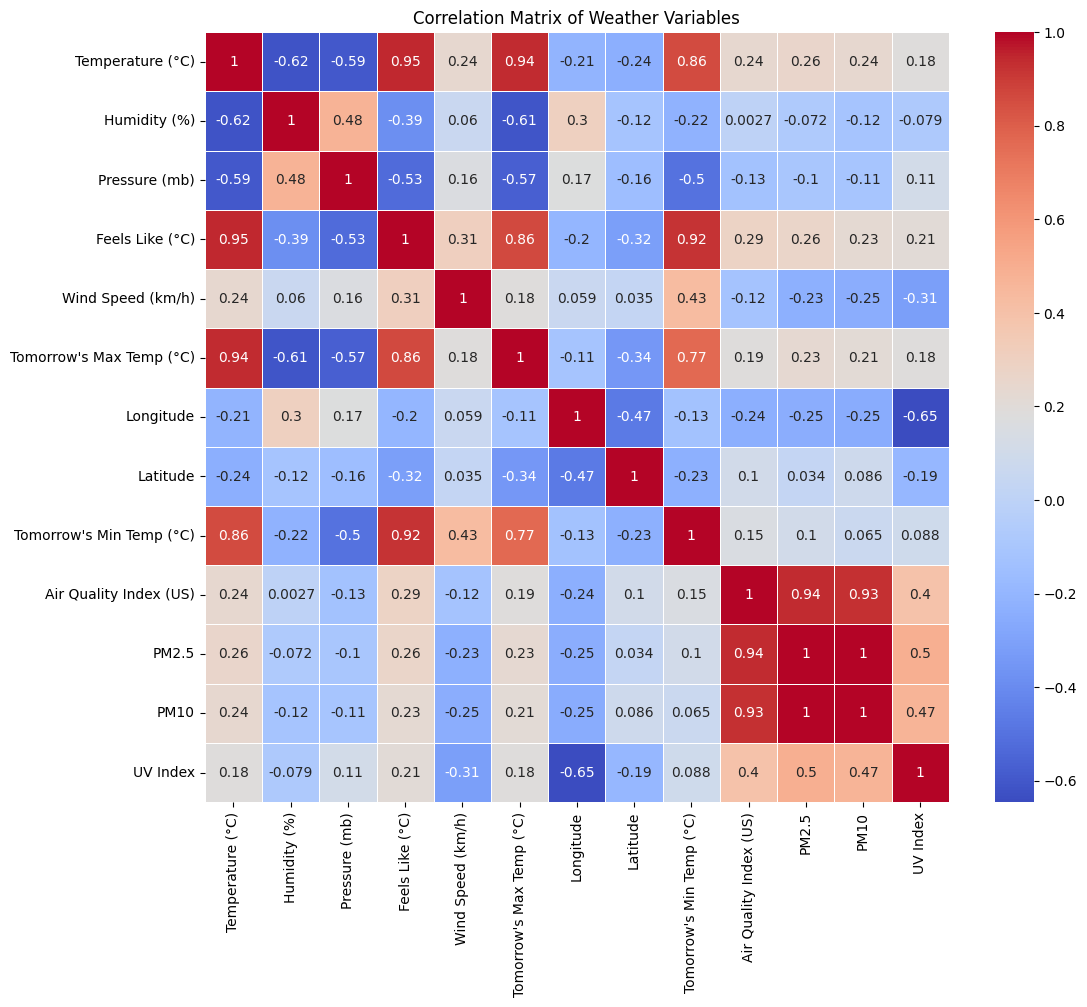

In [384]:

# Define relevant columns
col = [
    'Temperature (°C)', 'Humidity (%)', 'Pressure (mb)', 'Feels Like (°C)',
    'Wind Speed (km/h)', "Tomorrow's Max Temp (°C)","Longitude","Latitude",
    "Tomorrow's Min Temp (°C)","Air Quality Index (US)","PM2.5","PM10", "UV Index"
]

# Apply preprocessing to numerical columns for correlation analysis
numerical_data = df[col]  # Select numerical data

numerical_transformer = StandardScaler()  # Initialize scaler
numerical_data_scaled = numerical_transformer.fit_transform(numerical_data)  # Scale data

# Convert scaled data back into a DataFrame
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=col)

# Calculate the correlation matrix
correlation_matrix = numerical_data_scaled_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.show()


# **Data Pre-processing**

In [385]:
# make a copy of the df
df_copy = df.copy()
df_copy1=df_copy.copy()

In [386]:
from sklearn.preprocessing import StandardScaler

# List of columns to drop (including "Weather Condition")
columns_to_drop = [
    "City", "Country", "Local Time", "Visibility (km)", "Weather Condition", "Tomorrow's Condition", "Wind Direction","Longitude","Latitude"
]

# Drop unnecessary columns
df_copy.drop(columns=columns_to_drop, inplace=True)

# Convert 'Sunrise' and 'Sunset' to numerical features (minutes since midnight)
df_copy['Sunrise'] = pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunrise'], format='%I:%M %p').dt.minute
df_copy['Sunset'] = pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.hour * 60 + pd.to_datetime(df_copy['Sunset'], format='%I:%M %p').dt.minute

# Reset index
df_copy.reset_index(drop=True, inplace=True)

# Separate target variable
uv_index = df_copy[['UV Index']]

# Normalize humidity,air quality,PM2.5, PM10, CO, NO2,SO2,Temperature,Feels like, Min temperature,Max tempreature (excluding 'UV Index')

#standardize wind speed
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(df_copy.drop(columns=['UV Index']))

# Normalize the target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(uv_index)

# Convert scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=df_copy.columns[df_copy.columns != 'UV Index'])

# Add scaled 'UV Index' back
scaled_df['UV Index'] = scaled_target



**Creating sequences for the LSTM model**

In [387]:
# Define a function to create sequences
def create_sequences(data, target_column, seq_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].drop(columns=[target_column]).values
        target = data.iloc[i+seq_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM
seq_length = 30
X, y = create_sequences(df_copy, 'UV Index', seq_length)



In [388]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (°C)          42 non-null     float64
 1   Feels Like (°C)           42 non-null     float64
 2   Humidity (%)              42 non-null     int64  
 3   Pressure (mb)             42 non-null     float64
 4   Wind Speed (km/h)         42 non-null     float64
 5   UV Index                  42 non-null     float64
 6   Air Quality Index (US)    42 non-null     int64  
 7   PM2.5                     42 non-null     float64
 8   PM10                      42 non-null     float64
 9   CO (Carbon Monoxide)      42 non-null     float64
 10  NO2 (Nitrogen Dioxide)    42 non-null     float64
 11  SO2 (Sulfur Dioxide)      42 non-null     float64
 12  Tomorrow's Max Temp (°C)  42 non-null     float64
 13  Tomorrow's Min Temp (°C)  42 non-null     float64
 14  Sunrise     

**Train-Test split**

In [389]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# **Modelling**

**LSTM**

In [390]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 671430.5000 - val_loss: 1381451.2500
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1143965.3750 - val_loss: 1763334.6250
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 780174.8750 - val_loss: 1125328.6250
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 909433.1875 - val_loss: 930427.3125
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 918234.0000 - val_loss: 851587.1250
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 389504.0625 - val_loss: 659370.4375
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 475455.1562 - val_loss: 453714.5000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 437912.4375 - val_loss: 296755.7500
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 525884.0000 - val_loss: 88519.4062
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 143877.2812 - val_loss: 446321.6875
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - l

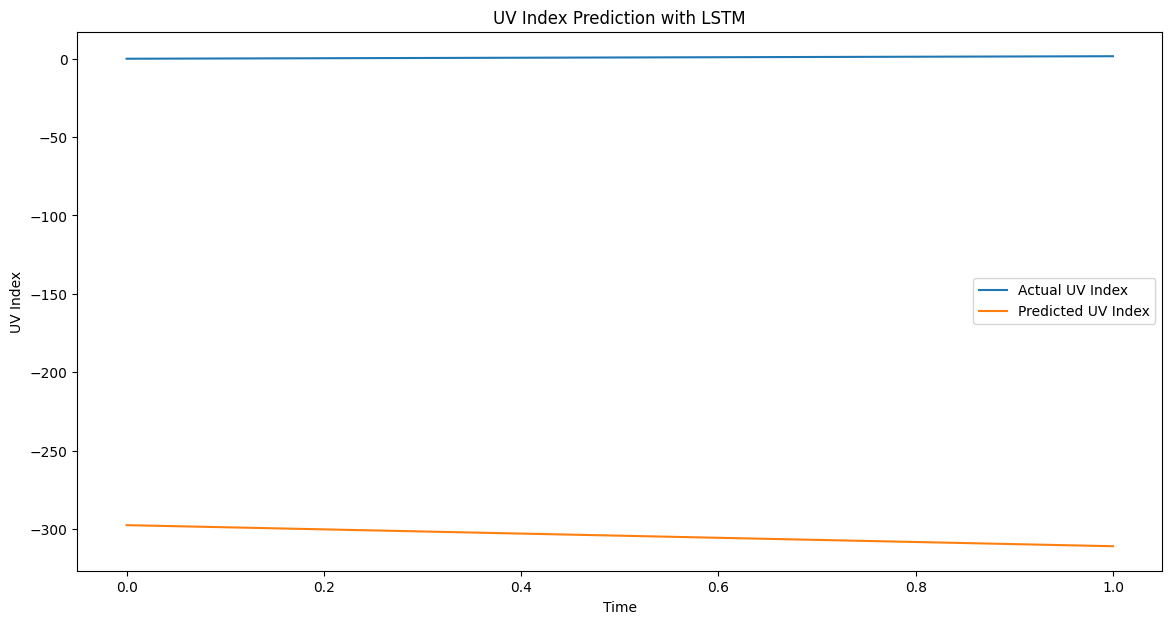

In [391]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f'Test Mean Squared Error: {mse}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values if necessary
y_test_inverse = y_test
y_pred_inverse = y_pred

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual UV Index')
plt.plot(y_pred_inverse, label='Predicted UV Index')
plt.legend()
plt.title('UV Index Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('UV Index')
plt.show()

**Hyperparameter Tuning using Randomized Search**

In [392]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam

# Function to create the LSTM model
def create_lstm_model(optimizer='adam', units=50, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Custom wrapper class to use Keras with scikit-learn's RandomizedSearchCV
class KerasClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, optimizer='adam', units=50, dropout_rate=0.2, activation='relu', epochs=10, batch_size=32):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y, **kwargs):
        # Create model
        self.model = self.build_fn(optimizer=self.optimizer, units=self.units,
                                    dropout_rate=self.dropout_rate, activation=self.activation)
        # Fit model with epochs and batch_size passed from search
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.evaluate(X, y)

# Wrap the model for use with RandomizedSearchCV
model = KerasClassifierCustom(build_fn=create_lstm_model)

# Define the hyperparameter grid to search, including epochs and batch_size
param_dist = {
    'epochs': [10, 20, 50],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100, 200],
    'dropout_rate': [0.2, 0.3, 0.5],
    'activation': ['relu', 'tanh', 'sigmoid']
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, cv=3, verbose=2, n_jobs=-1)
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search_result.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_model = random_search_result.best_estimator_

# Evaluate the model on validation/test data
score = best_model.score(X_val, y_val)
print(f"Model evaluation score: {score}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.2464
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0931
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2159
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.6575
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2703
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3260
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1963
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1611
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2883
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2313
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3908
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2910
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4041
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1386
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Mean Squared Error (MSE): 0.2775541527813629
R-squared (R²): -0.7347134548835179


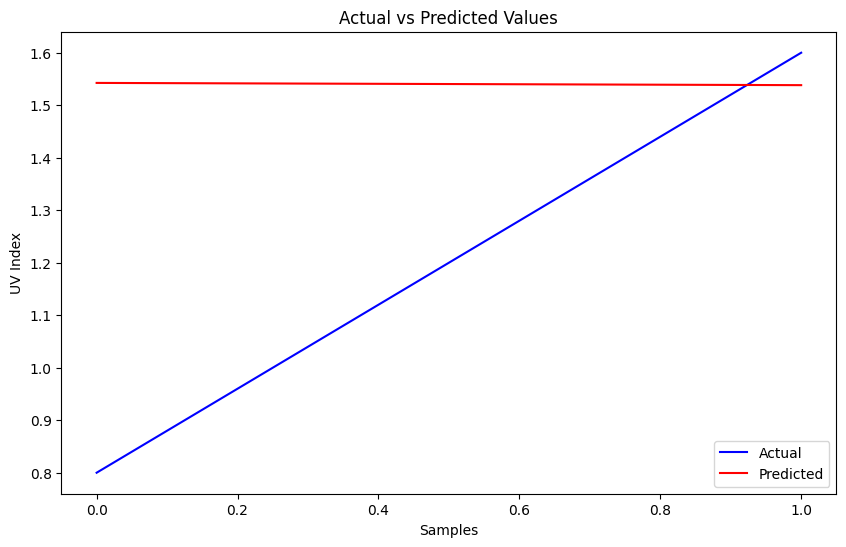

In [393]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Perform Randomized Search and get the best model as before

# Predict with the best model
y_pred = best_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R²)
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R²): {r2}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('UV Index')
plt.legend()
plt.show()


In [430]:
import csv
import random


# Function to recommend sunscreen based on UV index
def recommend_sunscreen(uv_index):
    if uv_index <= 2:
        spf_range = (15, 30)
    elif uv_index <= 5:
        spf_range = (30, 50)
    elif uv_index <= 7:
        spf_range = (50, 100)
    else:
        spf_range = (50, 100)

    # Filter sunscreens based on SPF range
    filtered_sunscreens = [s for s in sunscreens if spf_range[0] <= s["spf"] <= spf_range[1]]

    return random.choice(filtered_sunscreens) if filtered_sunscreens else None

# Generate sunscreen recommendations for each predicted UV index
spf_recommendations = [recommend_sunscreen(uv) for uv in y_pred]

# Print the recommendations
for uv, rec in zip(y_pred, spf_recommendations):
    if rec:
        print(f"UV Index: {uv} -> Recommended Sunscreen: {rec['name']} (SPF {rec['spf']})")
    else:
        print(f"UV Index: {uv} -> No suitable sunscreen found.")


UV Index: 3 -> Recommended Sunscreen: Blue Lizard Sensitive Mineral Sunscreen (SPF 50)
UV Index: 5 -> Recommended Sunscreen: Australian Gold Botanical Sunscreen Tinted Face (SPF 50)
UV Index: 8 -> Recommended Sunscreen: Banana Boat Ultra Sport Sunscreen (SPF 50)
UV Index: 10 -> Recommended Sunscreen: ISDIN Eryfotona Actinica Mineral Sunscreen (SPF 50)
UV Index: 2 -> Recommended Sunscreen: Derma E Sun Defense Mineral Oil-Free Sunscreen (SPF 30)
UV Index: 6 -> Recommended Sunscreen: Banana Boat Ultra Sport Sunscreen (SPF 50)


# **Streamlit App**

ModuleNotFoundError: No module named 'streamlit'